In [1]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from skimage.color import rgb2lab,lab2rgb
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio

In [3]:
def load_data(path):
    Input,Output,images=[],[],[]
    for i in tqdm(os.listdir(path)):
        path_=os.path.join(path,i)
        image=load_img(path_,target_size=(256,256),color_mode='rgb')
        image=img_to_array(image)
        image=image/255.0
        lab=rgb2lab(image)
        Input.append(lab[:,:,0])
        Output.append(lab[:,:,1:]/128)
    return np.array(Input),np.array(Output)

In [4]:
Input,Output=load_data('/kaggle/input/image-colorization-dataset/data/train_color')

100%|██████████| 5000/5000 [01:15<00:00, 66.27it/s]


In [5]:
print('Input shape is ' , Input.shape)
print('Output shape is ' , Output.shape)

Input shape is  (5000, 256, 256)
Output shape is  (5000, 256, 256, 2)


In [6]:
Input=np.expand_dims(Input,axis=-1)
print('Input shape is ' , Input.shape)
print('Output shape is ' , Output.shape)

Input shape is  (5000, 256, 256, 1)
Output shape is  (5000, 256, 256, 2)


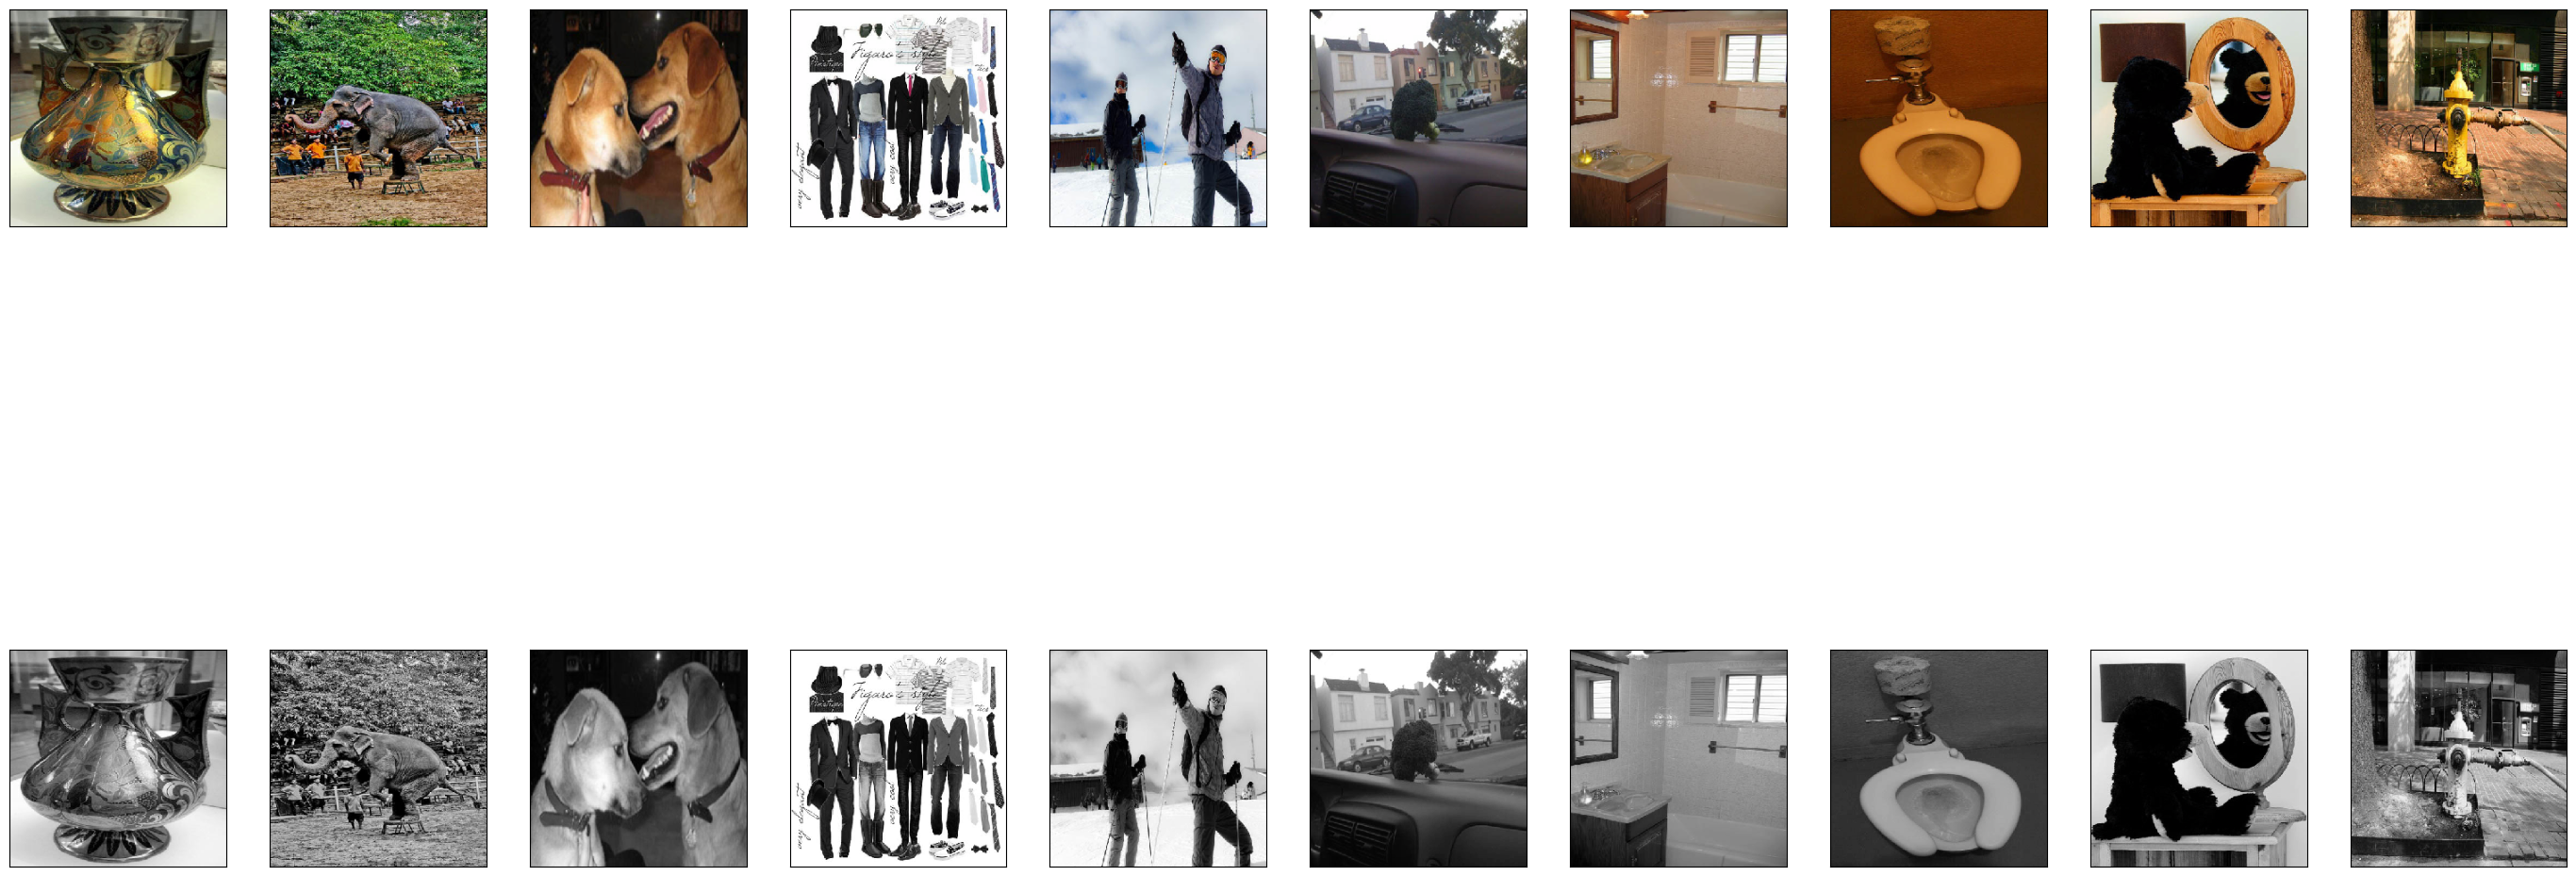

In [7]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    image=np.zeros((256,256,3))
    image[:,:,0]=Input[i][:,:,0]
    image[:,:,1:]=Output[i]*128
    plt.imshow(lab2rgb(image))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(Input[i],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(Input,Output, test_size=0.2, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (4000, 256, 256, 1)
X_test shape is  (1000, 256, 256, 1)
y_train shape is  (4000, 256, 256, 2)
y_test shape is  (1000, 256, 256, 2)


In [9]:
# Input layer with shape (200, 200, 1)
input_ = keras.layers.Input(shape=(256,256,1))
# Encoder
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu',strides=2)(input_)
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu',strides=2)(x)
x = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu',strides=2)(x)
x = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
encoder = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

# Decoder
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(encoder)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
# Adjust the output layer for an RGB image (2 channels)
x = keras.layers.Conv2D(2, (3, 3), padding='same', activation=keras.layers.LeakyReLU(alpha=.5))(x)
decoder = keras.layers.UpSampling2D((2, 2))(x)
# Autoencoder model
autoencoder = keras.models.Model(inputs=input_, outputs=decoder)
autoencoder.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 2)    │           290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,219,410 (23.73 MB)

 Trainable params: 6,219,410 (23.73 MB)

 Non-trainable params: 0 (0.00 B)

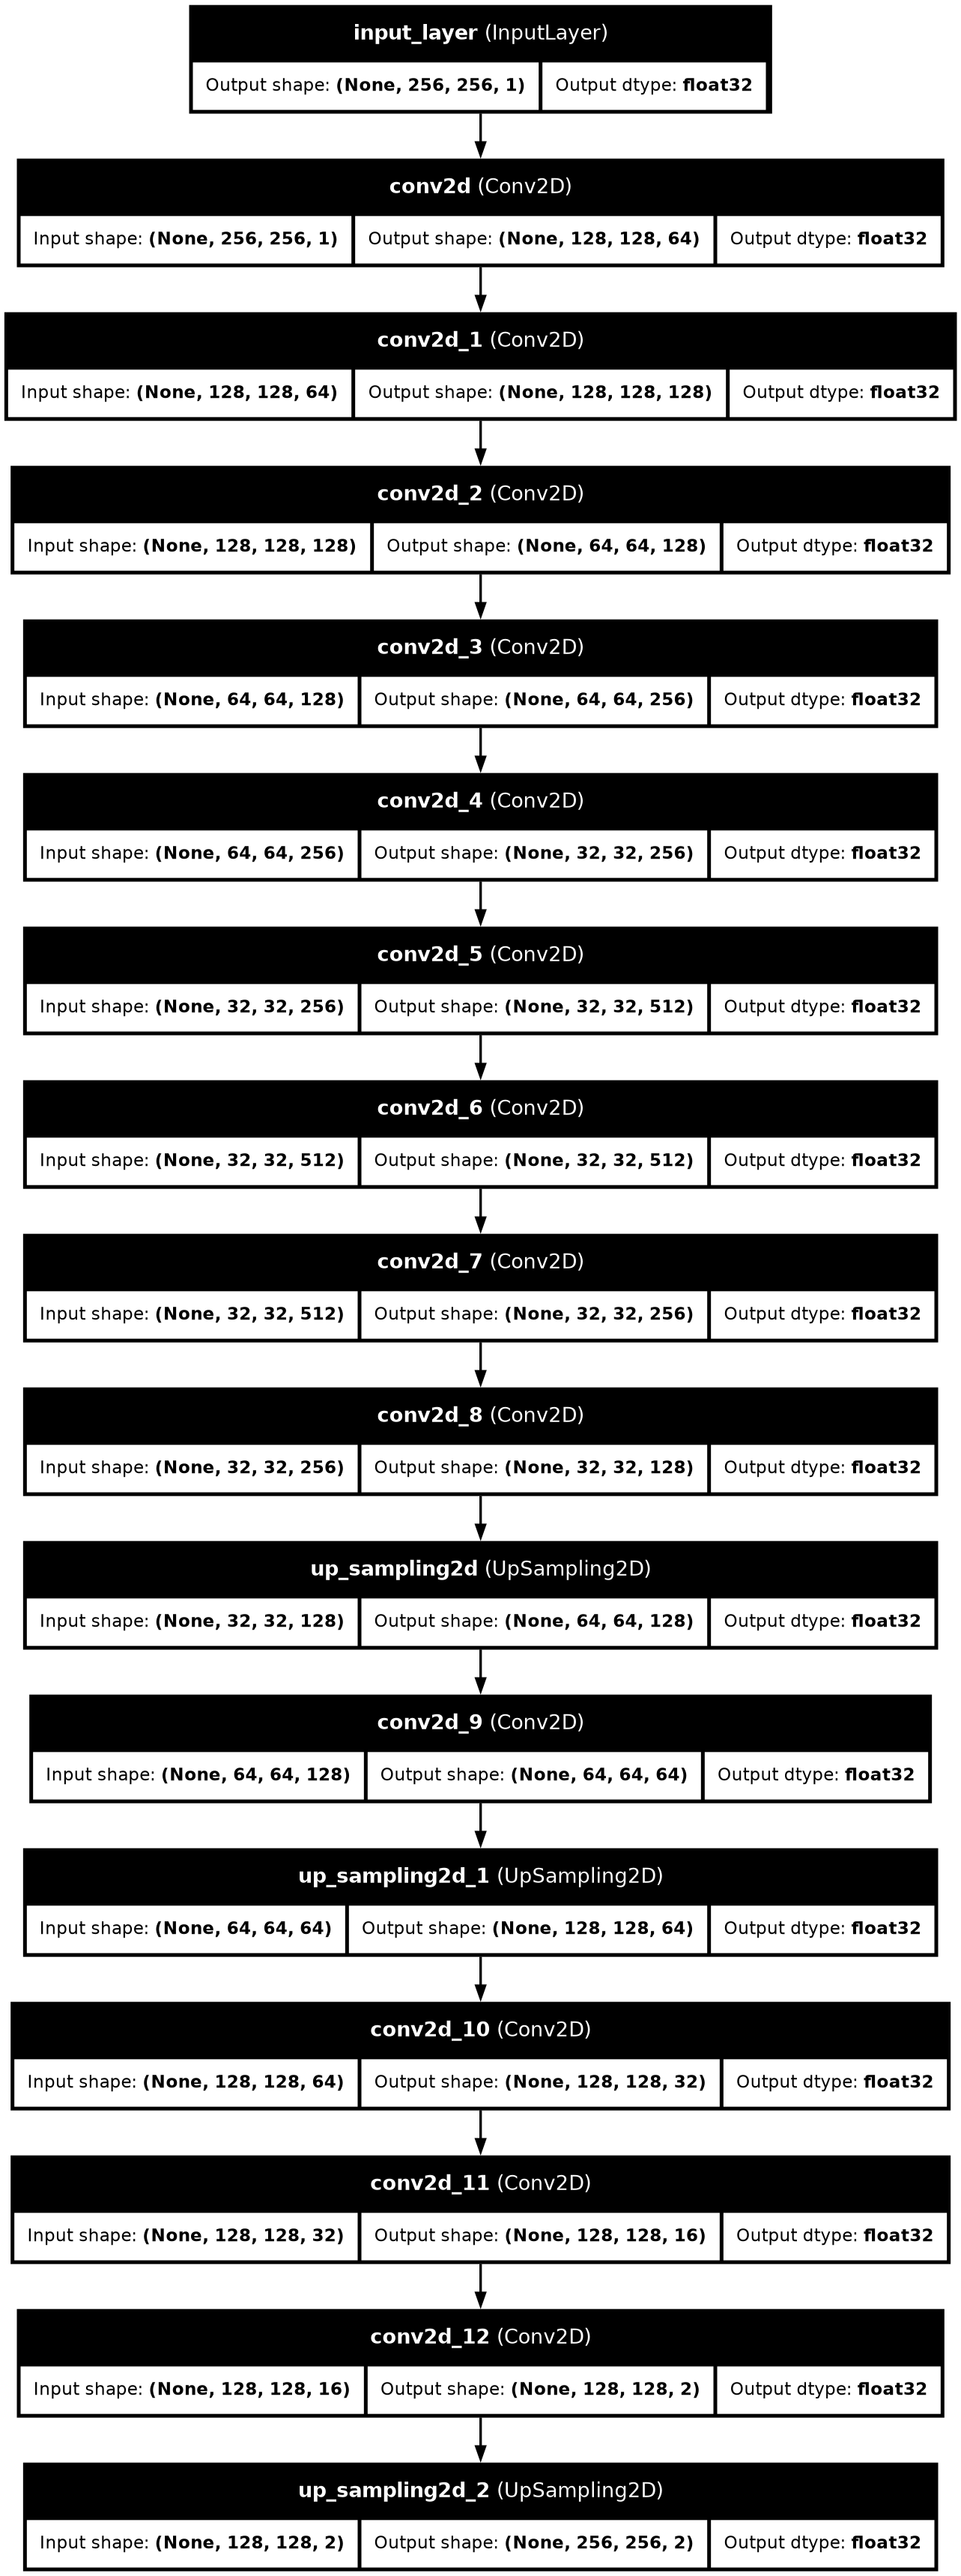

In [10]:
tf.keras.utils.plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [12]:
checkpoint_cb =ModelCheckpoint("autoencoder.keras",save_best_only=True)
autoencoder.compile(optimizer ='adam', loss='mse')
hist=autoencoder.fit(X_train,y_train,epochs=100,validation_split=.1,callbacks=[checkpoint_cb])

Epoch 1/100


I0000 00:00:1728281285.166692      99 service.cc:145] XLA service 0x7f60b8003640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728281285.168042      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/113 ━━━━━━━━━━━━━━━━━━━━ 42:19 23s/step - loss: 0.0346

I0000 00:00:1728281304.188246      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 273ms/step - loss: 0.3770 - val_loss: 0.0133
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - loss: 0.0128 - val_loss: 0.0133
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - loss: 0.0130 - val_loss: 0.0132
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - loss: 0.0129 - val_loss: 0.0130
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - loss: 0.0127 - val_loss: 0.0128
Epoch 11/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - loss: 0.0127 - val_loss: 0.0130
Epoch 12/100
113/113

In [13]:
hist_=pd.DataFrame(hist.history)
hist_

loss  val_loss
0   0.098587  0.013277
1   0.013133  0.013375
2   0.013106  0.013269
3   0.013074  0.013228
4   0.012960  0.013094
..       ...       ...
95  0.002150  0.013130
96  0.002127  0.013347
97  0.002141  0.013388
98  0.002127  0.013208
99  0.002288  0.013394

[100 rows x 2 columns]

In [14]:
autoencoder.save("final_autoencoder_model.keras")

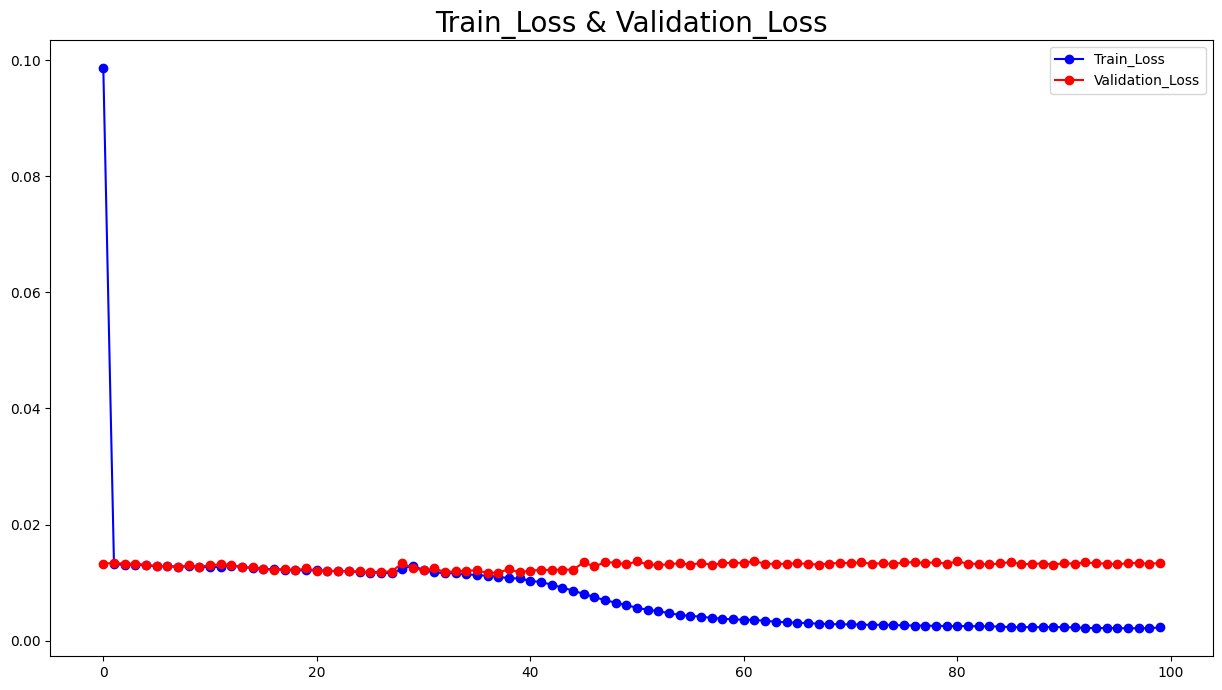

In [15]:
plt.figure(figsize=(15,8))
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.show()

In [16]:
autoencoder.evaluate(X_test,y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 0.0127


0.012755046598613262

In [17]:
predictions = autoencoder.predict(X_test)
predictions.shape

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


(1000, 256, 256, 2)

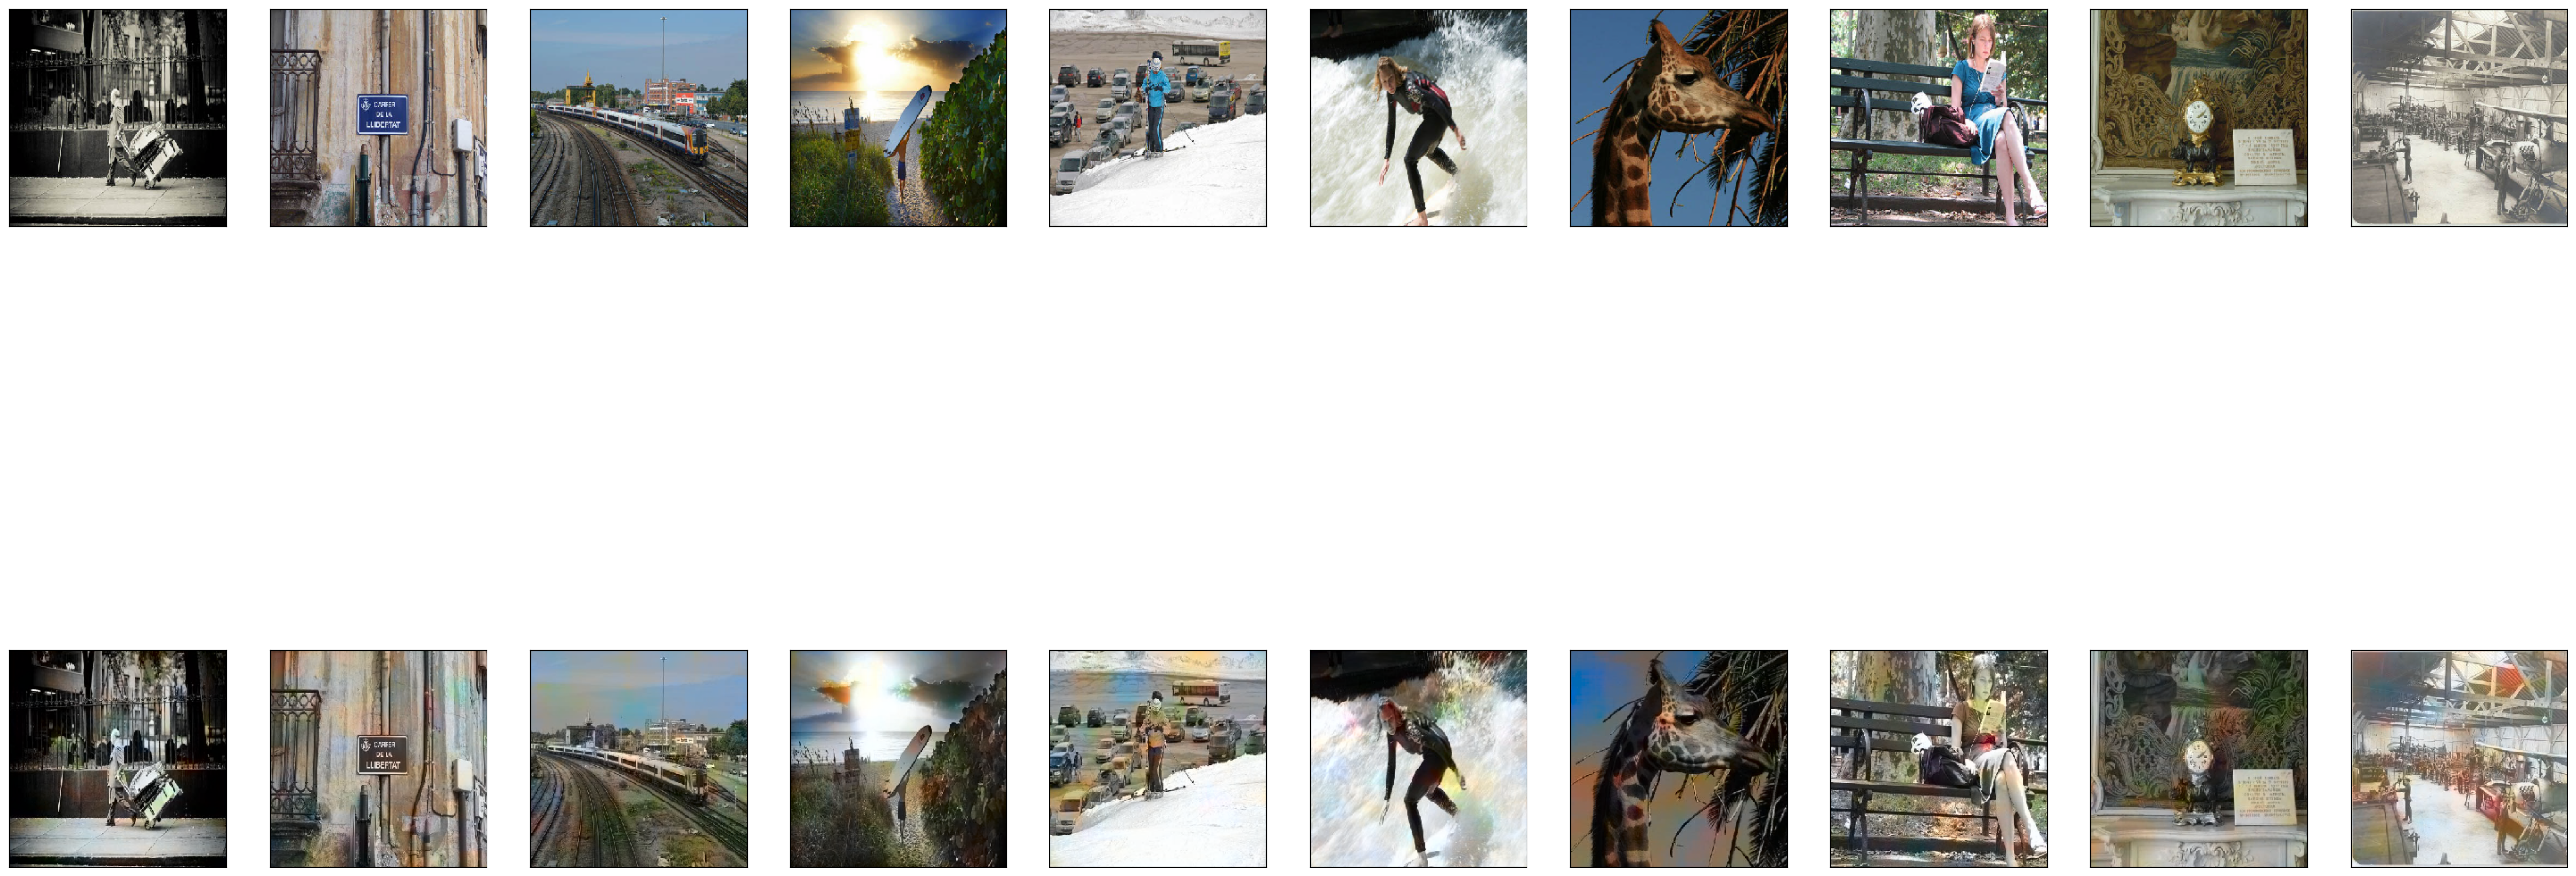

In [18]:
n = 10
plt.figure(figsize=(35, 25))
for i in range(n):
    # Display original gray images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display original color images
    ax = plt.subplot(3, n, i + 1)
    image = np.zeros((256, 256, 3))
    image[:, :, 0] = X_test[i][:,:,0]
    image[:, :, 1:] = y_test[i]* 128
    plt.imshow(lab2rgb(image))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display pred images
    ax = plt.subplot(3, n, i + 1 + n)
    image[:, :, 0] = X_test[i][:,:,0]
    image[:, :, 1:] = predictions[i]* 128
    plt.imshow(lab2rgb(image))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [19]:
psnr_values=[abs(peak_signal_noise_ratio(color,pred,data_range=color.max()-pred.min())) 
             for color,pred in zip(y_test,predictions)]
print('Average PSNR =',np.mean(psnr_values))

Average PSNR = 15.844628212867418
